# Tuning LoRA Hyperparameters - Layers/Memory

## Environment Setup

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
%%capture
import sys
sys.path.append('src')

import boto3

import sagemaker
from sagemaker.pytorch import PyTorch
from sagemaker.tuner import HyperparameterTuner

import warnings
warnings.filterwarnings('ignore')

from src.util import (
    count_parameters, 
    calc_combinations
)
from src.nb_helper import (
    display_tuning_jobs,
    get_default_estimator_parameters,
    p,
    capture_results,
    graph_results,
    roberta_total, 
    roberta_learnable
)
from amtviz import visualize_tuning_job
import altair as alt
sm = boto3.client('sagemaker')

## Experiments

Let's try some experiments. For all of the experiments we use one learning rate (and weight decay / dropout) as a basis. We use the learning rate we found with the tuning job.

In [3]:
# We continue to use the results of the base lora tuner
%store -r
assert base_lora_tuner_name
base_lora_tuner = HyperparameterTuner.attach(base_lora_tuner_name)
base_lora_tuner_name

'lora-base-tuning-231209-0038'

In [4]:
base_lora_tuner.wait()
desc = sm.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=base_lora_tuner.describe()['HyperParameterTuningJobName'])
print(desc['HyperParameterTuningJobName'], '=>', desc['HyperParameterTuningJobStatus'])
best_hyperparameters = desc['BestTrainingJob']['TunedHyperParameters']
print('Best parameters found:', best_hyperparameters)
best_hyperparameters = {k:float(v.replace('"', '')) for k, v in best_hyperparameters.items()}; best_hyperparameters

!
lora-base-tuning-231209-0038 => Completed
Best parameters found: {'sst2-epochs': '14', 'sst2-learning-rate': '0.001446695925631095'}


{'sst2-epochs': 14.0, 'sst2-learning-rate': 0.001446695925631095}

In [5]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, TuningJobCompletionCriteriaConfig
vertical_estimator = PyTorch(**get_default_estimator_parameters())
vertical_estimator.set_hyperparameters(**{'sst2-lora-r': 8, **best_hyperparameters})

n_trials = 3
hpt_ranges = {
    'use-gradient-checkpointing': CategoricalParameter([0, 1]),
    #'empty-cuda-cache': CategoricalParameter([0, 1]),
    'dummy': CategoricalParameter(list(range(0, n_trials))),
    'sst2-lora-config': CategoricalParameter([f'layer\\.{i}\\.' for i in range(12)])
}

tuner_parameters = {**(p('tuner_parameters') | dict(
    strategy='Grid',
    hyperparameter_ranges=hpt_ranges,
    metric_definitions=p('metric_definitions'),
    estimator = vertical_estimator,
    base_tuning_job_name = 'lora-layers',
    max_jobs = calc_combinations(hpt_ranges), 
    max_parallel_jobs = 10, 
))}


lora_layers_tuner = HyperparameterTuner(**tuner_parameters)
lora_layers_tuner.fit(wait=False)

Using provided s3_resource


### Analysis

#### Lora Layers

In [6]:
lora_layers_tuner.wait()

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [7]:
graph, trials_df, full_df = visualize_tuning_job(
    lora_layers_tuner,
    job_metrics=[
        "sst2_valid_acc",
        "train_loss",
        "learnable_parameters",
        "learning_rate",
        "gpu_memory",
        "epoch",
        "train_samples_sec",
    ],
    advanced=True,
    return_dfs=True
)

Tuning job lora-layers-231211-2229   status: Completed

Number of training jobs with valid objective: 72
Lowest: 0.7981651425361633 Highest 0.9392201900482178


,dummy,sst2-lora-config,use-gradient-checkpointing,TrainingJobName,TrainingJobStatus,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds,TuningJobName,sst2_valid_acc
39,1,layer\\.5\\.,0,lora-layers-231211-2229-033-c218b672,Completed,2023-12-11 23:21:14+01:00,2023-12-11 23:38:00+01:00,1006.0,lora-layers-231211-2229,0.939220
17,0,layer\\.9\\.,0,lora-layers-231211-2229-055-a71cd8d5,Completed,2023-12-11 23:55:08+01:00,2023-12-12 00:09:44+01:00,876.0,lora-layers-231211-2229,0.938073
23,0,layer\\.8\\.,0,lora-layers-231211-2229-049-a100a0fa,Completed,2023-12-11 23:45:36+01:00,2023-12-12 00:00:56+01:00,920.0,lora-layers-231211-2229,0.938073
13,2,layer\\.9\\.,0,lora-layers-231211-2229-059-6eb270d9,Completed,2023-12-12 00:00:10+01:00,2023-12-12 00:14:45+01:00,875.0,lora-layers-231211-2229,0.938073
61,2,layer\\.1\\.,0,lora-layers-231211-2229-011-c0d72bf1,Completed,2023-12-11 22:46:10+01:00,2023-12-11 23:06:41+01:00,1231.0,lora-layers-231211-2229,0.936927
19,2,layer\\.8\\.,0,lora-layers-231211-2229-053-e85fd852,Completed,2023-12-11 23:53:59+01:00,2023-12-12 00:09:18+01:00,919.0,lora-layers-231211-2229,0.935780
15,1,layer\\.9\\.,0,lora-layers-231211-2229-057-470b2841,Completed,2023-12-11 23:58:31+01:00,2023-12-12 00:13:07+01:00,876.0,lora-layers-231211-2229,0.935780
65,0,layer\\.1\\.,0,lora-layers-231211-2229-007-2021f12c,Completed,2023-12-11 22:31:19+01:00,2023-12-11 22:51:35+01:00,1216.0,lora-layers-231211-2229,0.934633
37,2,layer\\.5\\.,0,lora-layers-231211-2229-035-bd46fb50,Completed,2023-12-11 23:22:10+01:00,2023-12-11 23:39:10+01:00,1020.0,lora-layers-231211-2229,0.934633
63,1,layer\\.1\\.,0,lora-layers-231211-2229-009-fbdc25fa,Completed,2023-12-11 22:31:29+01:00,2023-12-11 22:51:40+01:00,1211.0,lora-layers-231211-2229,0.934633


Cache Hit/Miss: MMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMM


WARN shape dropped as it is incompatible with "bar".


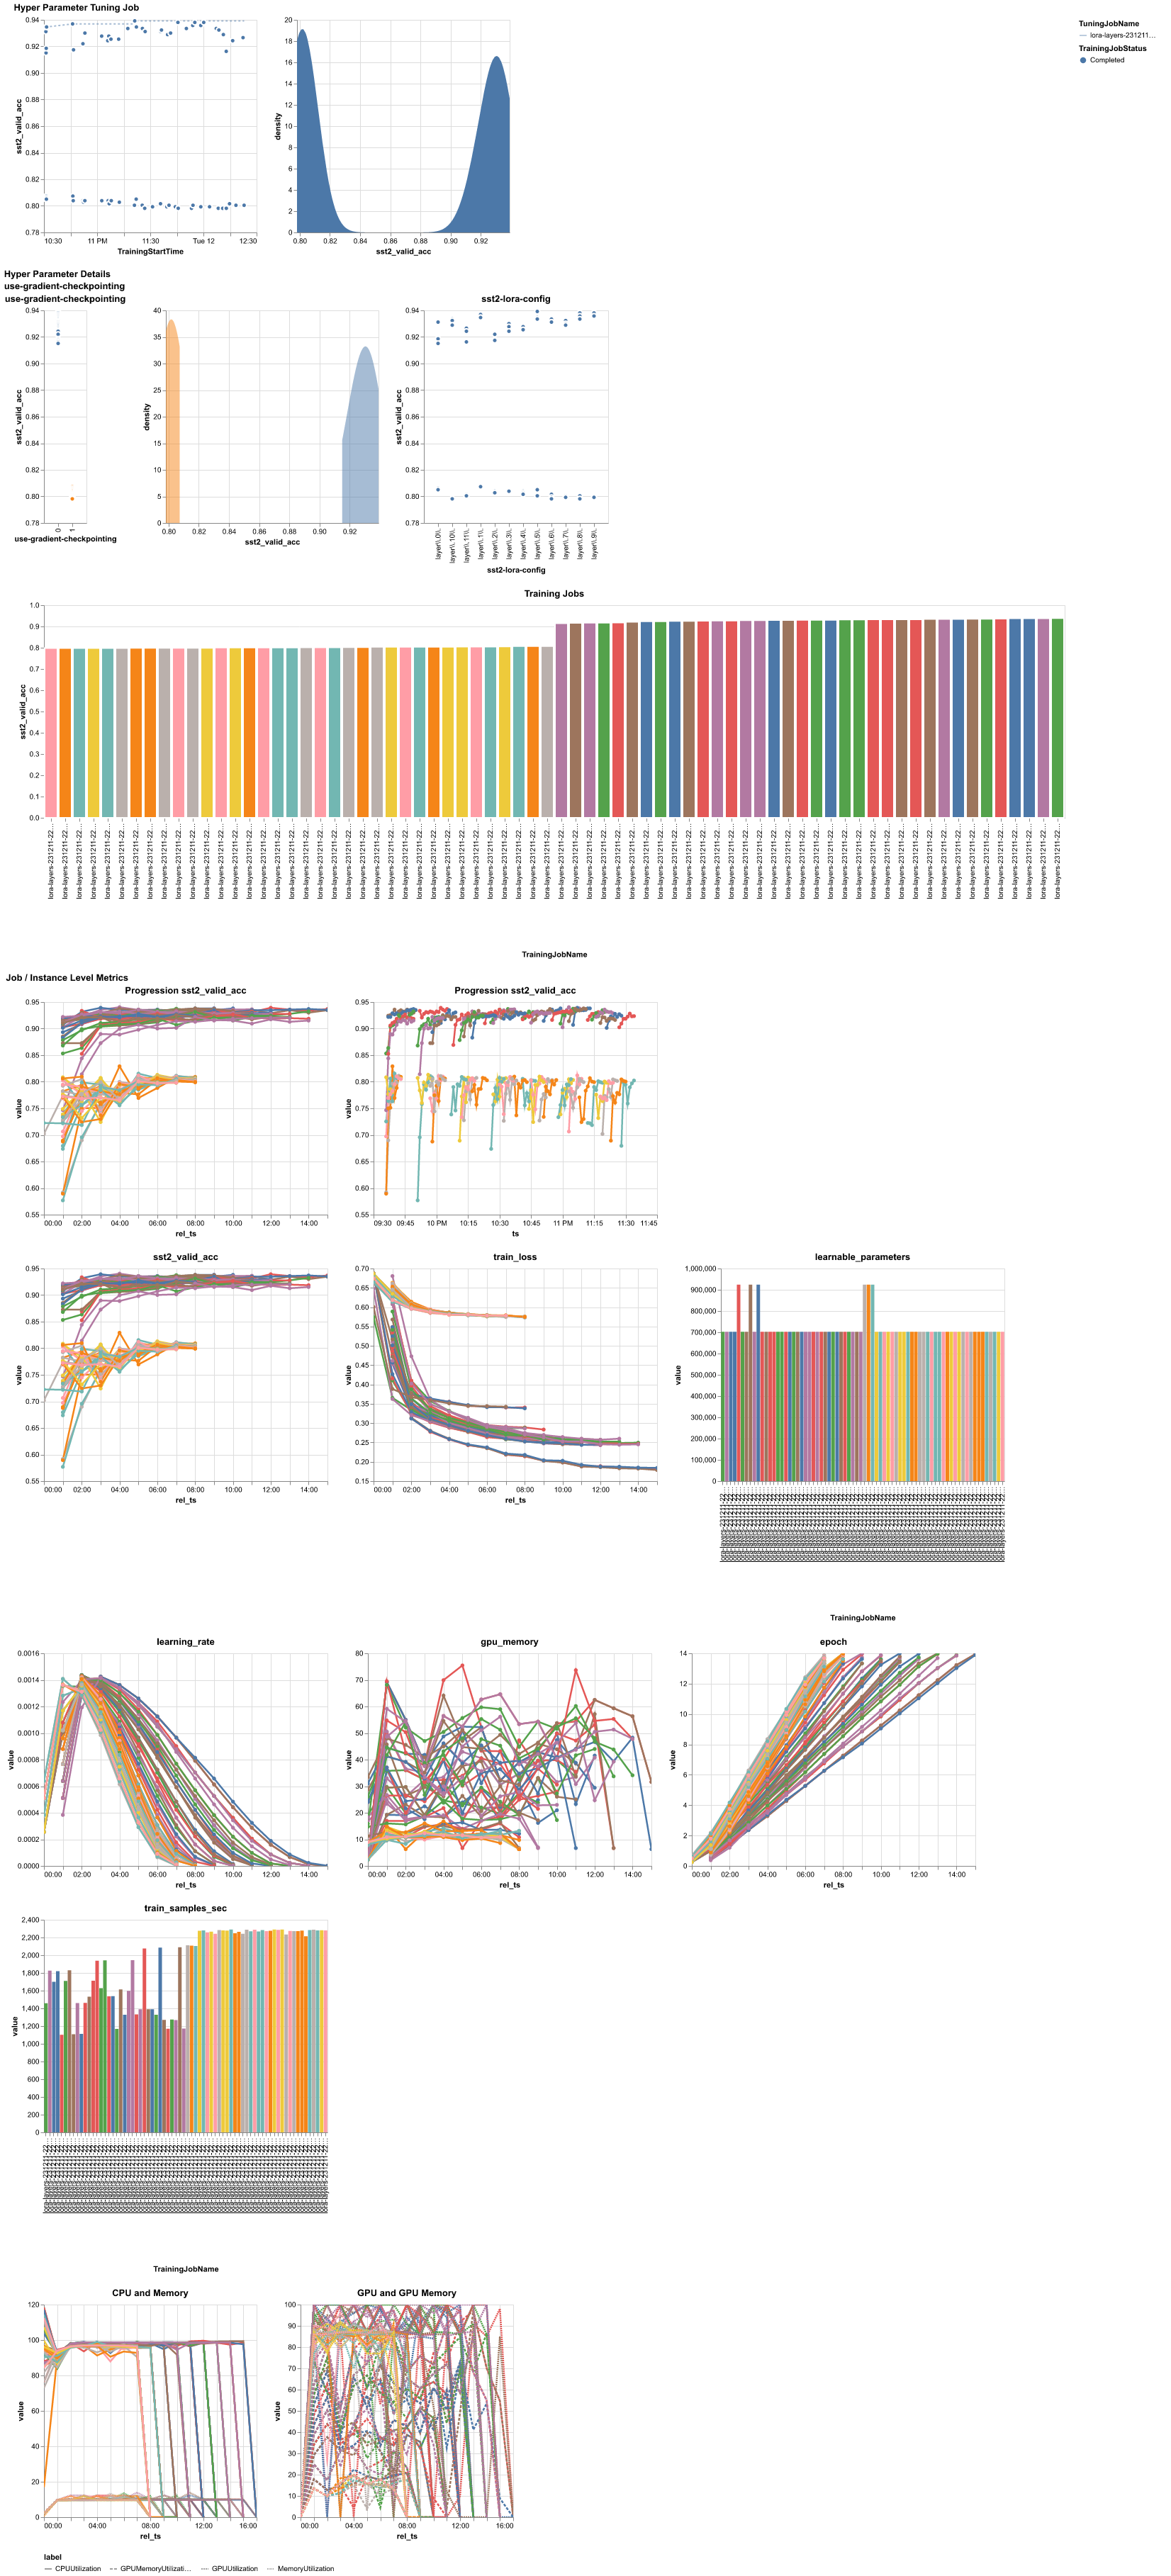

WARN FieldDef does not work with "linear" scale. We are using "point" scale instead.
WARN FieldDef does not work with "linear" scale. We are using "point" scale instead.
WARN x-scale's "base" is dropped as it does not work with point scale.
WARN x-scale's "base" is dropped as it does not work with point scale.
WARN x-scale's "zero" is dropped as it does not work with point scale.
WARN x-scale's "zero" is dropped as it does not work with point scale.
WARN Scale bindings are currently only supported for scales with unbinned, continuous domains.
WARN Scale bindings are currently only supported for scales with unbinned, continuous domains.


In [8]:
graph

In [9]:
full_df['layer'] =  full_df['sst2-lora-config'].str.extract('(\d+)').astype(int)+1

'---- gpu_memory ----'

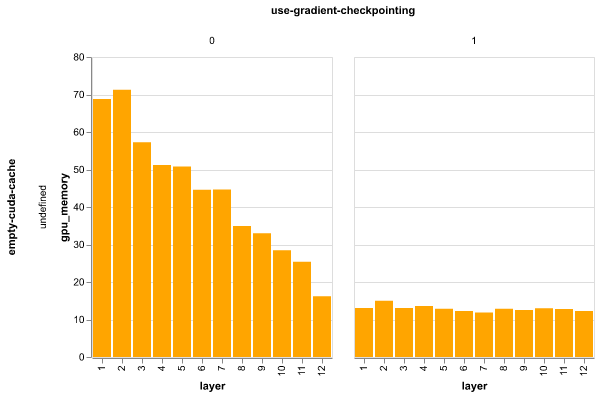

'---- sst2_valid_acc ----'

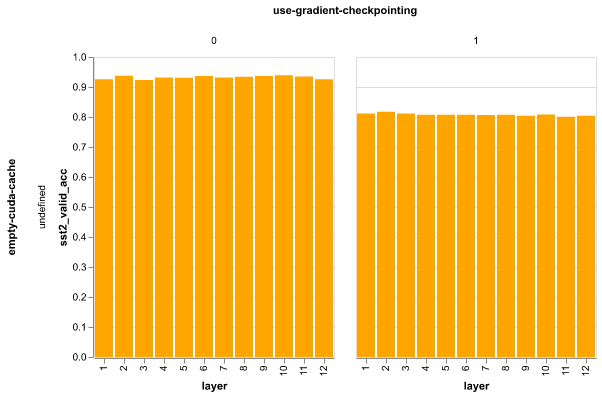

'---- train_samples_sec ----'

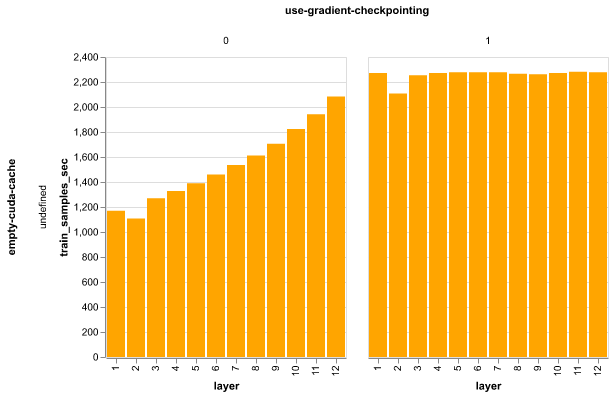

In [10]:
objectives = ["gpu_memory", "sst2_valid_acc", "train_samples_sec"]
for objective in objectives: 
    df = full_df[full_df.label == objective].sort_values('ts', ascending=False).groupby('TrainingJobName').max()

    display(f'---- {objective} ----')
    display(
        alt.Chart(df).mark_bar(color='orange', size=18).encode(
            y=alt.Y('mean(value):Q', title=objective),
            x=alt.X('layer:O'),
            column=alt.Column('use-gradient-checkpointing:N'),
            row=alt.Row('empty-cuda-cache:N'),
        )
    )